Report:
*   team members:
    1.   Ailing Li - ailingl2
    2.   Jesse Anderson - jander98
    3.   Kevin Nguyen - kn28

*   **Contribution from Ailing**
  - Tasks completed:
-   **Contribution from Jesse**
  - Tasks completed:
-   **Contribution from Kevin**
    - Tasks completed:

## Part I: Implement Lasso
### One-variable Lasso
First, write a function one_var_lasso that takes the following inputs:

\begin{aligned}
v = \begin{pmatrix}
v_1 & v_2 & \cdots & v_n
\end{pmatrix}^t,
\end{aligned}

\begin{aligned}
z = \begin{pmatrix}
z_1 & z_2 & \cdots & z_n
\end{pmatrix}^t ,
\end{aligned}

\begin{aligned}
\lambda > 0
\end{aligned}

and solves the following one-variable Lasso problem:
$$
\min_b { \frac{1}{2n} \sum_{i=1}^n (v_i - b z_i)^2 + \lambda |b|}
=
\min_b { \frac{1}{2n} \|v - b \cdot z\|^2 + \lambda |b|}
$$

In [ ]:
# install necessary libraries for the entire document
install.packages("pls")
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’




In [ ]:
# added by Ailing
one_var_lasso = function(v, z, lam) {
  n = length(v)

  # Compute v^T * z (dot product)
  v_transpose_z = sum(v * z)

  # Compute ||z||^2 (squared norm of z)
  norm_z_squared = sum(z^2)

  # check for denominator
  if (norm_z_squared == 0){
    return (0)
  }

  # Compute a
  a = v_transpose_z / norm_z_squared
  sign_a = sign(a) #positive return 1, negative return -1

  # Compute eta
  eta = (2 * n * lam) / norm_z_squared

  # Compute x*
  x_star = sign_a * max((abs(a) - eta / 2), 0)
  return (x_star)
}

### The CD Algorithm

Next, write your own function MyLasso to implement the Coordinate Descent (CD) algorithm by repeatedly calling one_var_lasso.
In the CD algorithm, at each iteration, we solve a one-variable Lasso problem for βj while holding the other (p-1) coefficients at their current values:
$$
\min_{\beta_j} { \frac{1}{2n} \sum_{i=1}^n \left( y_i - \sum_{k \neq j} X_{ik} \beta_k - X_{ij} \beta_j \right)^2 + \lambda \sum_{k \neq j} |\beta_k| + \lambda |\beta_j| }
$$

which is equivalent to solving the following one-variable Lasso problem
$$
\min_{\beta_j} { \frac{1}{2n} \sum_{i=1}^n \left( v_i - x_{ij} \beta_j \right)^2 + \lambda |\beta_j|},
\quad v_i = y_i - \sum_{k \neq j} x_{ik} \beta_k
$$

In [ ]:
#Your function may look like the following.
MyLasso = function(X, y, lam.seq, maxit = 100) {

    # Input
    # X: n-by-p design matrix without the intercept
    # y: n-by-1 response vector
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda

    # Output
    # B: a (p+1)-by-length(lam.seq) coefficient matrix
    #    with the first row being the intercept sequence

    n = length(y)
    p = dim(X)[2]
    nlam = length(lam.seq)
    B = matrix(0, ncol = nlam, nrow = (p+1))
    rownames(B) = c("Intercept", colnames(X))

    ##############################
    # YOUR CODE:
    # (1) new.X = centered & scaled X;
    # (2) record the centers and scales used in (1)
    ##############################

    # Initialize coef vector b and residual vector r
    b = rep(0, p)
    r = y

    # Triple nested loop
    for (m in 1:nlam) {
      for (step in 1:maxit) {
        for (j in 1:p) {
          r = r + (new.X[, j] * b[j])
          b[j] = one_var_lasso(r, new.X[, j], lam.seq[m])
          r = r - new.X[, j] * b[j]
        }
      }
      B[-1, m] = b
    }

    ##############################
    # YOUR CODE:
    # scale back the coefficients;
    # update the intercepts stored in B[1, ]
    ##############################

    return(B)
}

### Test Your Function

Download the data set Coding2_Data0.csv. The data set has 13 predictors, V1 to V13, and one response vector Y.

Test your function MyLasso on the data set Coding2_Data0.csv with a specific lambda sequence. Refer to the sample code in R/Python for the specified lambda sequence.



In [ ]:
library(pls)
myData = read.csv("Coding2_Data0.csv")
X = as.matrix(myData[, -14])
y = myData$Y
lam.seq = exp(seq(-1, -8, length.out = 80))
myout = MyLasso(X, y, lam.seq)

 - Check the accuracy of your function against the output from glmnet. The maximum difference between the two coefficient matrices should be less than 0.005.

In [ ]:
library(glmnet)
lasso.fit = glmnet(X, y, alpha = 1, lambda = lam.seq)
max(abs(coef(lasso.fit) - myout))

 - Produce a path plot for the 13 non-intercept coefficients along the lambda values in log scale.

In [ ]:
x.index = log(lam.seq)
beta = myout[-1, ]  # beta is a 13-by-80 matrix
matplot(x.index, t(beta),
        xlim = c(min(x.index), max(x.index)),
        lty = 1,
        xlab = "Log Lambda",
        ylab = "Coefficients",
        type="l",
        lwd = 1)
# You can add variable names to each path
var.names = colnames(X)
nvar = length(var.names)
xpos = rep(min(x.index), nvar)
ypos = beta[, ncol(beta)]
text(xpos, ypos, var.names, cex=0.5, pos=2)

Your plot should look almost the same as the plot from glmnet

In [ ]:
plot(lasso.fit, xvar = "lambda")

Compare the estimated Lasso coefficients from your function with those provided in Coding2_lasso_coefs.csv. The maximum difference between the two coefficient matrices should be **less than 0.005**.
Refer to the sample code for instructions on how to read in the coefficients from Coding2_lasso_coefs.csv.


## Part II: Simulation Study

Consider the following **six** procedures:

  - **Full**: Fit a linear regression model using all features
  - **Ridge.min**: Ridge regression using lambda.min
  - **Lasso.min** and **Lasso.1se**: Lasso using lambda.min or lambda.1se
  - **L.Refit**: Refit the model selected by Lasso using lambda.1se
  -	**PCR**: principle components regression with the number of components chosen by 10-fold cross validation

### Case I

Download the data set Coding2_Data1.csv. The first 14 columns are the same as the data set we used in Part I with Y being the response variable (moved to the 1st column). The additional 78 more predictors are the quadratic and pairwise product terms of the original 13 predictors.

In [ ]:
#Load libraries and data.
set.seed(2913)
library(glmnet)
library(pls)
myData = read.csv("Coding2_Data1.csv", header = TRUE)

-	[a] Conduct the following simulation exercise **50** times:
  
    –	In each iteration, randomly split the data into two parts, **75%** for training and **25%** for testing.
    
    –	For each of the **six** procedures, train a model using the training subset and generate predictions for the test subset. Record the **MSPE** (Mean Squared Prediction Error) based on these test data predictions.
    
  -	[b] Graphically summarize your findings on the MSPE using a strip chart, and consider overlaying a boxplot for additional insights.
  
  -	[c] Based on the outcomes of your simulation study, please address the following questions:
  
    –	Which procedure or procedures yield the best performance in terms of MSPE? – Conversely, which procedure or procedures show the poorest performance?
    
    –	In the context of Lasso regression, which procedure, **Lasso.min** or **Lasso.1se**, yields a better MSPE?
    
    –	Is refitting advantageous in this case? In other words, does **L.Refit** outperform **Lasso.1se**?
    
    –	Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the **Full** model to be comparable to, or divergent from, the best-performing procedure among the other five?

In [ ]:
T = 50
n = length(Y)
ntest = round(n * 0.25)  # test set size
ntrain = n - ntest  # training set size
all.test.id = matrix(0, ntest, T)  #
for(t in 1:T){
  all.test.id[, t] = sample(1:n, ntest)
}
#save(all.test.id, file="alltestID.RData")

### Case II

Download the data set Coding2_Data2.csv. The first 92 columns are identical to those in Coding2_Data1.csv, with the addition of 500 columns of artificially generated **noise features**.


In [ ]:
library(pls)
set.seed(2913) # will remove later
#upload file to session storage first
data2 = read.csv("Coding2_Data2.csv", header = TRUE)
dim(data2)
# skip first column
data2_X = data.matrix(data2[,-1]) #skip first column y matrix
data2_Y = data2[,1] #only first column y vector

[1] 506 592

-	Repeat [a] and [b] above for the **four** procedures **excluding** the **Full** procedure. Graphically summarize your findings on MSPE using a strip chart, and consider overlaying a boxplot for additional insights.

In [ ]:
data2_n = length(data2_Y)
data2_test_size = round(data2_n * 0.25) #testing data size
data2_train_size = data2_n - data2_test_size #training data size

# a 25x50 matrix holds all the test ids
# initializing to 0s
all.data2test.id = matrix(0, data2_test_size, T)

for(t in 1:T){
  all.data2test.id[, t] = sample(1:data2_n, data2_test_size)
}

# create a vector filled with the first column of all.data2test.id matrix
data2test.id = all.data2test.id[, 1]

### Ridge

In [ ]:
library(glmnet)
mylasso.lambda.seq = exp(seq(-10, 1, length.out = 100))
cv.out = cv.glmnet(data2_X[-data2test.id, ], data2_Y[-data2test.id], alpha = 0,
                   lambda = mylasso.lambda.seq)

best.lam = cv.out$lambda.min
data2.Ytest.pred = predict(cv.out, s = best.lam, newx = data2_X[data2test.id, ])
#MSPE calculation
mspe_ridge = mean((data2_Y[data2test.id] - data2.Ytest.pred)^2)

### Lasso

In [ ]:
cv.out = cv.glmnet(data2_X[-data2test.id, ], data2_Y[-data2test.id], alpha = 1)
best.lam = cv.out$lambda.min
data2.Ytest.pred = predict(cv.out, s = best.lam, newx = data2_X[data2test.id, ])
mspe_lasso = mean((data2_Y[data2test.id] - data2.Ytest.pred)^2)

### Lasso Refit

In [ ]:
mylasso.coef = predict(cv.out, s = best.lam, type = "coefficients")
var.sel = row.names(mylasso.coef)[which(mylasso.coef != 0)[-1]]
mylasso.refit = lm(Y ~ ., data2[-data2test.id, c("Y", var.sel)])
data2.Ytest.pred = predict(mylasso.refit, newdata = data2[data2test.id, ])
mspe_lasso_refit = mean((data2.Ytest.pred - data2_Y[data2test.id])^2)

### PCR

In [ ]:
library(pls)
#The default pcr does not scale the input features
mypcr = pcr(Y ~ ., data= data2[-data2test.id, ], validation="CV", scale=TRUE)
CVerr = RMSEP(mypcr)$val[1, , ]
adjCVerr = RMSEP(mypcr)$val[2, , ]
best.ncomp = which.min(CVerr) - 1

if (best.ncomp==0) {
    Ytest.pred = mean(data2$Y[-data2test.id])
  } else {
    data2.Ytest.pred = predict(mypcr, data2[data2test.id,], ncomp=best.ncomp)
  }
mspe_pcr = mean((data2.Ytest.pred - data2$Y[data2test.id])^2)

-	[c] Address the following questions:
  
    –	Which procedure or procedures yield the best performance in terms of MSPE?
    

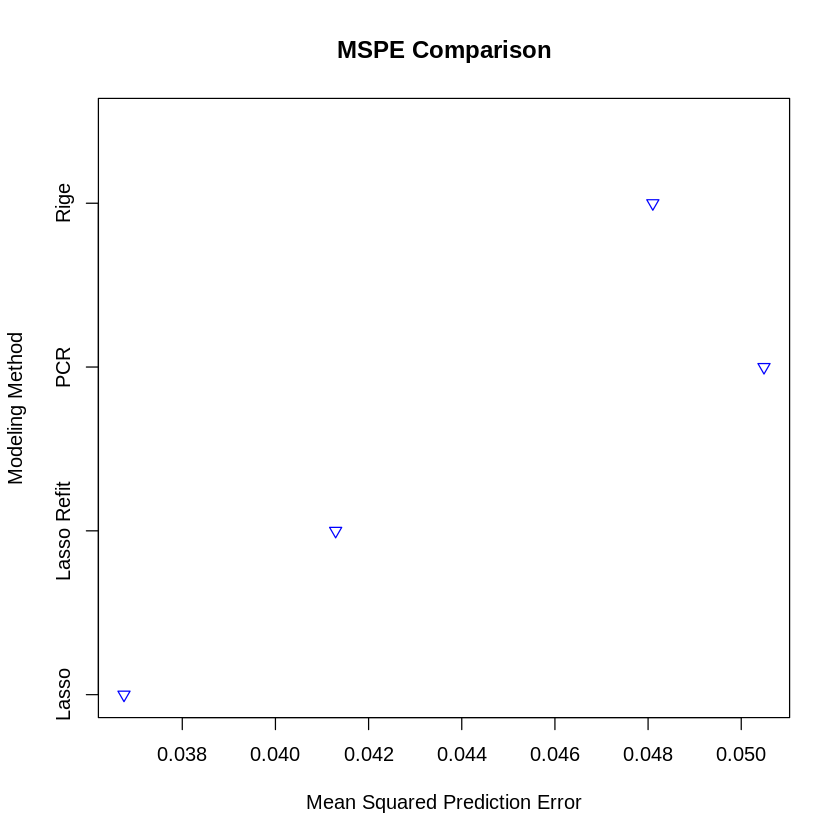

In [ ]:
mspe_results = data.frame(
  Method = c("Rige", "Lasso", "Lasso Refit", "PCR"),
  MSPE = c(mspe_ridge, mspe_lasso, mspe_lasso_refit, mspe_pcr)
)

stripchart(MSPE ~ Method, data = mspe_results,
           main = "MSPE Comparison",
           xlab = "Mean Squared Prediction Error",
           ylab = "Modeling Method",
           method = "stack", #"jitter",
           col = "blue",
           vertical = FALSE,
           pch = 25)


  –	Conversely, which procedure or procedures show the poorest performance?
    
  –	Have you observed any procedure or procedures that performed well in Case I but exhibited poorer performance in Case II, or vice versa? If so, please offer an explanation.
    
  –	Given that Coding2_Data2.csv includes all features found in Coding2_Data1.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case I. Do your simulation results corroborate this expectation? If not, please offer an explanation.

### What to Submit

  -	A Markdown (or Notebook) file in HTML format, which contains all necessary code and the corresponding output/results.
  -	RMD or ipynb files are not needed.
  -	Set the **seed** at the beginning of part II to be the last 4-dig of your UIN. So we can get the same result if we re-run your code. If your UIN ends with “0496”, for example, use “496.”
  -	**One submission per team**. For each assignment, one and only one member submits their work on Coursera/Canvas. Please remember to include the following in your report:
–	the names and netIDs of all team members; the program (MCS-DS or campus) if the team is a mixture of students from these two;
–	a short paragraph detailing the contribution of each member.